#  Capstone Project - Opening a Restaurant in Toronto

This notebook is organized into the following sections:
1. <b> Libraries and Configuration </b> needed for the exercise
2. <b> Global Variables </b> used throughout notebook
3. <b> Helper Functions </b> for loading and processing the data
4. <b> Load Toronto Data - Census Data & Geo Location </b>
5. <b> Visualization Helper Functions </b>
6. <b> Census Data Feature Selection </b> used for neighbourhood clustering (age, after-tax household income, and family type)
7. <b> Build Neighbourhood Clusters and Get Top Venues by Cluster </b> using kmeans and Four Square data
8. <b> Compare Neighbourhood Clusters </b>
9. <b> Cluster Comparison Summary </b> including restaurant opening recommendations 

        


## 1.  Libraries and Configuration

Load in the libraries that will be needed for this analysis.

In [1]:
import os
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim 

# Matplotlib and associated plotting modules
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

mpl.style.use('ggplot') # optional: for ggplot-like style


# import k-means from clustering stage
from sklearn.cluster import KMeans

# map rendering library
import folium 

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)




## 2.  Global Variables

Set the global variables used throughout the notebook

In [2]:
INDEX_FILENAME = 'C:\\Users\\Allen\\Desktop\\projects\\github-sample\\Geo_starting_row_CSV.csv'
CENSUS_FILENAME = 'C:\\Users\\Allen\\Desktop\\projects\\github-sample\\98-401-X2016046_English_CSV_data.csv'
ROWS_PER_POSTALCODE = 2247

GEOCODE_FILENAME = 'C:\\Users\\Allen\\Desktop\\projects\\github-sample\\Geospatial_Coordinates.csv'
#TORONTO_POSTALCODE_LINK = 'C:\\Users\\Allen\\Desktop\\projects\\github-sample\\List of postal codes of Canada_ M - Wikipedia.html'
TORONTO_POSTALCODE_LINK = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

GEOJSON_FILENAME = 'C:\\Users\\Allen\\Desktop\\projects\\github-sample\\Toronto2.geojson'

# Four Square access credentials
CLIENT_ID =  
CLIENT_SECRET =  
VERSION = '20180605'

index_df = pd.DataFrame()

## 3. Helper Functions

### 3.1 read_index_table

Reads the index file and returns a table which maps the postal code to the census data for that postal code 


In [3]:
def read_index_table ():
    df = pd.read_csv (INDEX_FILENAME, skiprows=[1])
    df.drop ('Geo Code', axis=1, inplace=True)
    df.columns = ['Postal Code', 'Index']
    df.set_index('Postal Code', inplace=True)
    return df

# Test read_index_table
#read_index_table_df = read_index_table()
#print (read_index_table_df.head())
#read_index_table_df.shape
    
    

### 3.2 raw_census_by_postalcode

Reads in and returns a dataframe of the complete census data based on the postal code

In [4]:
def raw_census_by_postalcode (postalcode):
    global index_df
    if (index_df.empty):
        print ("Index table is empty.")
        index_df = read_index_table()
    index = index_df.loc[postalcode, 'Index']
    print ('Reading postal code {} rows {} to {}'.format(postalcode, index-1, index-1+ROWS_PER_POSTALCODE))
    df = pd.read_csv (CENSUS_FILENAME, skiprows=range(1,index-1), nrows = ROWS_PER_POSTALCODE)
    return df

# Test read_census_by_postalcode
#test_postalcode = 'L6C'
#raw_census_by_postalcode_df = raw_census_by_postalcode(test_postalcode)
#raw_census_by_postalcode_df.head()

### 3.3 cleanse_census_df

Given the complete census data and postal code, filters out data that will not be used and maps the data that will be used to be more understandable.

In [5]:
# clean up the dataframe and convert into a row with columns of interest

def cleanse_census_df (raw_census_df, postal_code):
    # only keep the columns that are of interest
    df = raw_census_df [['DIM: Profile of Forward Sortation Areas (2247)',
                        'Dim: Sex (3): Member ID: [1]: Total - Sex']]
    
    # change the column names as this will be easier to work with
    df.columns = ['Feature', postal_code]
    
    # remove rows that are not interesting; highly manual
    
    # Total Population Data
    df.at[0, 'Feature'] = 'Population: 2016'
    df.drop([1], inplace=True) # 2011 population which seems to be '...' for every postal code
    df.drop([2], inplace=True) # population change %
    df.drop([4], inplace=True) # private dwellings occupied by usual residents
    
    df.drop([5,6], inplace=True) # population density, land area in square km (no data)
    df.drop([7], inplace=True) # total population, should be a duplicate of row 0
    
    # Age Data
    df.drop([8,12,23,28], inplace=True) # these are age group aggregates: 0-14, 15-64, 65+, and 85+
    df.drop(range(33,38), inplace=True) # distribution of population that could be calculated by Age Groups
    
    df.at[38, 'Feature'] = 'Average age'
    df.at[39, 'Feature'] = 'Median age'
    
    # Dwelling Data
    df.at[40, 'Feature'] = 'Number dwellings'
    df.at[41, 'Feature'] = 'Single-detached'
    df.at[42, 'Feature'] = 'High-rise apartment'
    df.drop([43], inplace=True) # aggregate for other dwellings which include all the ones below
    df.at[44, 'Feature'] = 'Semi-detached'
    df.at[45, 'Feature'] = 'Row house'
    df.at[46, 'Feature'] = 'Flat or duplex'
    df.at[47, 'Feature'] = 'Low-rise apartment'
    df.at[48, 'Feature'] = 'Other single-detached'
    df.at[49, 'Feature'] = 'Movable dwelling'
    
    # Household Data
    df.at[50, 'Feature'] = 'Number private households'
    df.at[51, 'Feature'] = '1 person household'
    df.at[52, 'Feature'] = '2 person household'
    df.at[53, 'Feature'] = '3 person household'
    df.at[54, 'Feature'] = '4 person household'
    df.at[55, 'Feature'] = '5+ person household'
    df.at[56, 'Feature'] = 'Total persons in private households'
    
    # Family Data
    df.at[58, 'Feature'] = 'Number marital status'  # those aged 15+
    df.drop([59, 62], inplace=True) # aggregate for married/common law and not married/common law
    df.at[60, 'Feature'] = 'Married'
    df.at[61, 'Feature'] = 'Common law'
    df.at[63, 'Feature'] = 'Never married'
    df.at[64, 'Feature'] = 'Separated'
    df.at[65, 'Feature'] = 'Divorced'
    df.at[66, 'Feature'] = 'Widowed'
    
    # Household & Family data
    df.at[67, 'Feature'] = 'Number of families'  # Census family is married, common-law, or single parent with child(ren)
    df.at[68, 'Feature'] = '2 person families'
    df.at[69, 'Feature'] = '3 person families'
    df.at[70, 'Feature'] = '4 person families'
    df.at[71, 'Feature'] = '5+ person families'
    
    df.drop([73], inplace=True) # This is the same as 67: Number of families
    df.drop([74, 77], inplace=True) # aggregate married/common law families and single parent families
    df.at[75, 'Feature'] = 'Married familes'
    df.at[76, 'Feature'] = 'Common law families'
    df.at[78, 'Feature'] = 'Female parent families'
    df.at[79, 'Feature'] = 'Male parent families'
    
    df.drop([80], inplace=True) # This is the same as 74: Census families in private households, couple families
    df.at[81, 'Feature'] = 'Couple families with no children'
    df.drop([82], inplace=True) # aggregate for couples with children
    df.at[83, 'Feature'] = 'Couple families with 1 child'
    df.at[84, 'Feature'] = 'Couple families with 2 children'
    df.at[85, 'Feature'] = 'Couple families with 3+ children'

    df.drop([86], inplace=True) # This is the same as 77: Census families in private households, single parent
    df.at[87, 'Feature'] = 'Single parent with 1 child'
    df.at[88, 'Feature'] = 'Single parent with 2 children'
    df.at[89, 'Feature'] = 'Single parent with 3+ children'
    
    df.at[90, 'Feature'] = 'Number of singles'  # in contrast to the number of families
    
    df.drop ([91], inplace=True) # This is the same as 50, Total private households
    df.drop ([92], inplace=True) # One-census-family households aggregate
    df.at[93, 'Feature'] = 'Households with 1 family and no children'
    df.at[94, 'Feature'] = 'Households with 1 family with children'
    df.at[95, 'Feature'] = 'Households with 2+ families'
    df.drop ([96], inplace=True) # Non-census-family households
    df.at[97, 'Feature'] = 'Households with 1 single'
    df.at[98, 'Feature'] = 'Households with 2+ singles'
    
    # drop languanges spoken
    df.drop(range(99,660), inplace=True)
    
    # drop some of the income statistics
    df.drop([660], inplace=True)
    df.at[661, 'Feature'] = 'Number income recipients'
    df.at[662, 'Feature'] = 'Median of income recipients'
    df.at[663, 'Feature'] = 'Number after-tax income recipients'
    df.at[664, 'Feature'] = 'Median of after-tax income recipients'    
    df.drop(range(665,690), inplace=True)
    
    # Income Data for Individuals (before tax)
    df.at[690, 'Feature'] = 'Number invidivuals: income'
    df.at[691, 'Feature'] = 'No income'
    df.drop ([692], inplace=True) # aggregate for individuals with income
    df.at[693, 'Feature'] = '% with income'
    df.at[694, 'Feature'] = 'Income <$10000'
    df.at[695, 'Feature'] = 'Income \$10000-$19999'
    df.at[696, 'Feature'] = 'Income \$20000-$29999'
    df.at[697, 'Feature'] = 'Income \$30000-$39999'
    df.at[698, 'Feature'] = 'Income \$40000-$49999'
    df.at[699, 'Feature'] = 'Income \$50000-$59999'
    df.at[700, 'Feature'] = 'Income \$60000-$69999'
    df.at[701, 'Feature'] = 'Income \$70000-$79999'
    df.at[702, 'Feature'] = 'Income \$80000-$89999'
    df.at[703, 'Feature'] = 'Income \$90000-$99999'
    df.drop ([704], inplace=True) # aggregate total 100000+
    df.at[705, 'Feature'] = 'Income \$100000-$149999'
    df.at[706, 'Feature'] = 'Income \$150000+'

    
    # Income Data for Individuals (after tax)
    df.at[707, 'Feature'] = 'Number after-tax income'
    df.at[708, 'Feature'] = 'No after-tax income'
    df.drop ([709], inplace=True) # aggregate for individuals with after-tax income
    df.at[710, 'Feature'] = '% with after-tax income'
    df.at[711, 'Feature'] = 'After-tax income <$10000'
    df.at[712, 'Feature'] = 'After-tax income \$10000-$19999'
    df.at[713, 'Feature'] = 'After-tax income \$20000-$29999'
    df.at[714, 'Feature'] = 'After-tax income \$30000-$39999'
    df.at[715, 'Feature'] = 'After-tax income \$40000-$49999'
    df.at[716, 'Feature'] = 'After-tax income \$50000-$59999'
    df.at[717, 'Feature'] = 'After-tax income \$60000-$69999'
    df.at[718, 'Feature'] = 'After-tax income \$70000-$79999'
    df.drop ([719], inplace=True) # aggregate total 80000+
    df.at[720, 'Feature'] = 'After-tax income \$80000-$89999'
    df.at[721, 'Feature'] = 'After-tax income \$90000-$99999'
    df.at[722, 'Feature'] = 'After-tax income $100000+'

    # Employment income statistics
    df.drop(range(723,740), inplace=True) 
    
    # Income Data for Households
    df.at[740, 'Feature'] = 'Number household income'
    df.at[741, 'Feature'] = 'Median total household income'
    df.at[742, 'Feature'] = 'Median after-tax household income'
    df.drop (range(743,749), inplace=True) # additional data about income earners per household
    df.drop(range(749,758), inplace=True) # 25% data
    df.drop([758], inplace=True) # same data as 740: Number of household income'
    df.at[759, 'Feature'] = 'Household income <$5000'
    df.at[760, 'Feature'] = 'Household income \$5000-$9999'
    df.at[761, 'Feature'] = 'Household income \$10000-$14999'
    df.at[762, 'Feature'] = 'Household income \$15000-$19999'
    df.at[763, 'Feature'] = 'Household income \$20000-$24999'
    df.at[764, 'Feature'] = 'Household income \$25000-$29999'
    df.at[765, 'Feature'] = 'Household income \$30000-$34999'
    df.at[766, 'Feature'] = 'Household income \$35000-$39999'
    df.at[767, 'Feature'] = 'Household income \$40000-$44999'
    df.at[768, 'Feature'] = 'Household income \$45000-$49999'
    df.at[769, 'Feature'] = 'Household income \$50000-$59999'
    df.at[770, 'Feature'] = 'Household income \$60000-$69999'
    df.at[771, 'Feature'] = 'Household income \$70000-$79999'
    df.at[772, 'Feature'] = 'Household income \$80000-$89999'
    df.at[773, 'Feature'] = 'Household income \$90000-$99999'
    df.drop ([774], inplace=True) # aggregate total 100000+
    df.at[775, 'Feature'] = 'Household income \$100000-$124999'
    df.at[776, 'Feature'] = 'Household income \$125000-$149999'
    df.at[777, 'Feature'] = 'Household income \$150000-$199999'
    df.at[778, 'Feature'] = 'Household income $200000+'

    # Income Data for Households, after tax
    df.drop([779], inplace=True) # same data as 740: Number of household income'
    df.at[780, 'Feature'] = 'Household after-tax income <$5000'
    df.at[781, 'Feature'] = 'Household after-tax income \$5000-$9999'
    df.at[782, 'Feature'] = 'Household after-tax income \$10000-$14999'
    df.at[783, 'Feature'] = 'Household after-tax income \$15000-$19999'
    df.at[784, 'Feature'] = 'Household after-tax income \$20000-$24999'
    df.at[785, 'Feature'] = 'Household after-tax income \$25000-$29999'
    df.at[786, 'Feature'] = 'Household after-tax income \$30000-$34999'
    df.at[787, 'Feature'] = 'Household after-tax income \$35000-$39999'
    df.at[788, 'Feature'] = 'Household after-tax income \$40000-$44999'
    df.at[789, 'Feature'] = 'Household after-tax income \$45000-$49999'
    df.at[790, 'Feature'] = 'Household after-tax income \$50000-$59999'
    df.at[791, 'Feature'] = 'Household after-tax income \$60000-$69999'
    df.at[792, 'Feature'] = 'Household after-tax income \$70000-$79999'
    df.at[793, 'Feature'] = 'Household after-tax income \$80000-$89999'
    df.at[794, 'Feature'] = 'Household after-tax income \$90000-$99999'
    df.drop ([795], inplace=True) # aggregate total 100000+
    df.at[796, 'Feature'] = 'Household after-tax income \$100000-$124999'
    df.at[797, 'Feature'] = 'Household after-tax income \$125000-$149999'
    df.at[798, 'Feature'] = 'Household after-tax income $150000+'
    
    # Remove rest of income data
    df.drop (range(799, 871), inplace = True)
    
    # data from these features are from the long form census which was filled only by ~25% of the population
    df.drop(range(871,2247), inplace=True)
    
    return df

# Test cleanse_census_df
#test_postalcode = 'A0A'
#raw_df = raw_census_by_postalcode(test_postalcode)
#cleansed_df = cleanse_census_df (raw_df, test_postalcode)
#cleansed_df.loc[0:2247]

### 3.4 convert_features_to_columns

Because the census data for a postal code is stored in name/value pairs in the data file, the read in data frame needs to be transposed so the features are columns and the row is the postal code.

In [6]:
# Convert a cleansed df, where the features are in a column, to where the features are the columns
def convert_features_to_columns (feature_df):
    to_column_df = feature_df.set_index('Feature').T
    to_column_df.index.names = ['Postal Code']
    return to_column_df

# Test convert_feature_to_columns 
#test_postalcode = 'L6C'
#test_raw_df = raw_census_by_postalcode(test_postalcode)
#test_cleansed_df = cleanse_census_df (test_raw_df, test_postalcode)
#test_converted_df = convert_features_to_columns (test_cleansed_df)
#test_converted_df


### 3.5 get_census_data

Given a list of postal codes (forward sortation area), return a dataframe of the features in columns and postal code as rows.

In [7]:
def get_census_data (postal_code_list):
    df = pd.DataFrame()
    for pc in postal_code_list:
        raw_df = raw_census_by_postalcode (pc)
        cleansed_df = cleanse_census_df (raw_df, pc)
        converted_df= convert_features_to_columns (cleansed_df)
        df = df.append (converted_df)
    
    # covert all the columns from a string to numeric
    for col in df.columns:
        df[col] = pd.to_numeric (df[col])
    
    return df.reset_index()

# Test get_census_data
#postal_code_list = ['L6C','M6G', 'M6H']
#census_df = get_census_data (postal_code_list)
#census_df
#census_df.describe()


### 3.6 get_Toronto_postal_coordinates

Return a dataframe of postal codes along with their geo coordinates corresponding to the city of Toronto 

In [8]:
def get_Toronto_postal_coordinates ():

    raw_page = requests.get(TORONTO_POSTALCODE_LINK)
    bs = BeautifulSoup (raw_page.text, 'lxml')

    postal_table = bs.find ('tbody')
    cols = ['Postal Code', 'Borough', 'Neighborhood']
    postal_df = pd.DataFrame(columns=cols)

    # first row contains the table header information
    for r, row in enumerate (postal_table.find_all('tr')[1:]):
        postalcode = ""
        borough = ""
        neighborhood = ""

        for c, col in enumerate (row.find_all('td')):
            if (c == 0):
                postalcode = col.text
            elif (c == 1):
                borough = col.text
            elif (c == 2):
                neighborhood = col.text.rstrip()
            else:
                print ('Should never get here')

        # Use the borough name if the neighborhood has not been assigned
        if (neighborhood == "Not assigned"):
            neighborhood = borough

        # if the borough is not assigned, then skip this row
        if (borough != "Not assigned"):
            dup_df = postal_df[postal_df ['Postal Code'] == postalcode]
            if (not dup_df.empty):
                idx = dup_df.index.values.astype(int)[0]
                appended_nh = neighborhood + ', ' + dup_df.loc[idx, 'Neighborhood'] 
                postal_df.loc[idx, 'Neighborhood'] = appended_nh
            else: 
                temp_df = pd.DataFrame ({'Postal Code': [postalcode], 'Borough': [borough], 'Neighborhood': [neighborhood]})
                postal_df = postal_df.append(temp_df, ignore_index=True)
        
    geo_df = pd.read_csv(GEOCODE_FILENAME)
    
    # merge the dataframes using the postal code of each dataframe as the key
    postal_geo_df = postal_df.merge (geo_df, on='Postal Code')
    #postal_geo_df = geo_df
    
    return postal_geo_df

### 3.7 getNearbyVenues

Returns nearby venues given a geocoordinates and radius. 

In [38]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## 4. Load Toronto Data - Census Data & Geo Location

Read in the census data for the city of Toronto. 

Toronto has postal codes that are not residential areas and hence, will have no corresponding census data.  These need to be removed.

In [10]:
toronto_coords_df = get_Toronto_postal_coordinates()

# Remove postal codes that are commercial areas and will have no census data
# M7R Postal processing centre
# M7A Queen's Park
# M5K TD Centre, Design exchange
# M5L Victoria Hotel, Commerce Court
# M5W The Esplanade
# M5X Underground City, First Canadian Place
# M7Y Postal processing centre
postal_remove_list = ['M7R', 'M7A', 'M5K', 'M5L', 'M5W', 'M5X', 'M7Y']

toronto_coords_df = toronto_coords_df[toronto_coords_df['Postal Code'].map(lambda x: str(x) not in postal_remove_list)].reset_index(drop=True)
toronto_coords_df.set_index('Postal Code')
toronto_coords_df.head()


Postal Code           Borough                      Neighborhood   Latitude  \
0         M3A        North York                         Parkwoods  43.753259   
1         M4A        North York                  Victoria Village  43.725882   
2         M5A  Downtown Toronto         Regent Park, Harbourfront  43.654260   
3         M6A        North York  Lawrence Manor, Lawrence Heights  43.718518   
4         M9A         Etobicoke                  Islington Avenue  43.667856   

   Longitude  
0 -79.329656  
1 -79.315572  
2 -79.360636  
3 -79.464763  
4 -79.532242

Read in the census data for Toronto (based on the postal code list)

In [11]:
toronto_postalcode_list = toronto_coords_df['Postal Code']
toronto_census_df = get_census_data (toronto_postalcode_list)
toronto_census_df.set_index('Postal Code')
toronto_census_df.head()


Index table is empty.
Reading postal code M3A rows 2067241 to 2069488


C:\Users\Allen\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Reading postal code M4A rows 2087464 to 2089711
Reading postal code M5A rows 2130157 to 2132404
Reading postal code M6A rows 2170603 to 2172850
Reading postal code M9A rows 2217790 to 2220037
Reading postal code M1B rows 2011066 to 2013313
Reading postal code M3B rows 2069488 to 2071735
Reading postal code M4B rows 2089711 to 2091958
Reading postal code M5B rows 2132404 to 2134651
Reading postal code M6B rows 2172850 to 2175097
Reading postal code M9B rows 2220037 to 2222284
Reading postal code M1C rows 2013313 to 2015560
Reading postal code M3C rows 2071735 to 2073982
Reading postal code M4C rows 2091958 to 2094205
Reading postal code M5C rows 2134651 to 2136898
Reading postal code M6C rows 2175097 to 2177344
Reading postal code M9C rows 2222284 to 2224531
Reading postal code M1E rows 2015560 to 2017807
Reading postal code M4E rows 2094205 to 2096452
Reading postal code M5E rows 2136898 to 2139145
Reading postal code M6E rows 2177344 to 2179591
Reading postal code M1G rows 2017807 to 

Feature Postal Code  Population: 2016  Total private dwellings  0 to 4 years  \
0               M3A             34615                    13847          1795   
1               M4A             14443                     6299           670   
2               M5A             41078                    24186          1555   
3               M6A             21048                     8751          1190   
4               M9A             35594                    15730          1435   

Feature  5 to 9 years  10 to 14 years  15 to 19 years  20 to 24 years  \
0                1975            2040            2270            2365   
1                 715             650             765             860   
2                1280            1185            1490            3140   
3                1310            1340            1500            1395   
4                1570            1755            1955            2320   

Feature  25 to 29 years  30 to 34 years  35 to 39 years  40 to 44 years  \
0                  2320            2250            2340            2410   
1                   900             900            1020             885   
2                  5010            5180            3895            3080   
3                  1215            1350            1550            1400   
4                  2625            2470            2285            2185   

Feature  45 to 49 years  50 to 54 years  55 to 59 years  60 to 64 years  \
0                  2560            2800            2405            1850   
1                  1005            1100            1030             930   
2                  3150            3135            2590            2230   
3                  1385            1405            1235            1070   
4                  2480            2735            2660            2345   

Feature  65 to 69 years  70 to 74 years  75 to 79 years  80 to 84 years  \
0                  1520            1195             950             800   
1                   770             620             610             470   
2                  1725            1075             640             390   
3                   905             675             615             600   
4                  1920            1350            1115            1015   

Feature  85 to 89 years  90 to 94 years  95 to 99 years  100 years and over  \
0                   535             185              35                   5   
1                   300             180              45                   5   
2                   210              85              25                   5   
3                   445             370             105                  10   
4                   775             465             110                  20   

Feature  Average age  Median age  Number dwellings  Single-detached  \
0               40.0        39.9             13245             2555   
1               43.8        44.2              6170             1260   
2               39.3        37.0             22335              115   
3               40.4        39.0              8075             1485   
4               43.2        43.1             15120             5000   

Feature  High-rise apartment  Semi-detached  Row house  Flat or duplex  \
0                       6710           1355       1310             115   
1                       2145            310        360             190   
2                      16170            350       1730             235   
3                       2705             65        775             450   
4                       8465            170        280              65   

Feature  Low-rise apartment  Other single-detached  Movable dwelling  \
0                      1180                     15                 0   
1                      1890                     15                 0   
2                      3665                     65                 5   
3                      2585                     10                 0   
4                   

### 4.1 Describe Toronto Census Data

We can see from the data, 96 postal codes (forward sortation areas) were read in.  Looking at the population, the average size of each postal area is around 28,500 people, but range quite considerable from 2,005 to 75,897.

The following census information was extracted for each postal code:
* Total population for 2016
* Number of private dwellings
* Breakdown of the population living in detached, townhome, condo, or high-rise (dwellings)
* Ages already bucketed
* Household sizes
* Marital status (for those 15 years of age and older)
* Number and size of families
* Marital status groupings (e.g., married, common law)
* Family and number of kids groupings
* Income levels of the population before tax and after tax
* Household income levels before tax and after tax

In [12]:
toronto_census_df.describe()


Feature  Population: 2016  Total private dwellings  0 to 4 years  \
count           96.000000                96.000000     96.000000   
mean         28459.312500             12284.187500   1417.447917   
std          14007.981457              6171.844265    796.218693   
min           2005.000000              1718.000000     50.000000   
25%          18531.250000              8175.500000    786.250000   
50%          25724.000000             11215.500000   1392.500000   
75%          37820.500000             15744.000000   1910.000000   
max          75897.000000             36123.000000   3540.000000   

Feature  5 to 9 years  10 to 14 years  15 to 19 years  20 to 24 years  \
count       96.000000       96.000000       96.000000       96.000000   
mean      1406.770833     1324.166667     1516.406250     2029.114583   
std        822.753714      785.620997      893.051158     1140.357514   
min         15.000000       10.000000       45.000000      185.000000   
25%        821.250000      803.750000      872.500000     1197.500000   
50%       1272.500000     1187.500000     1362.500000     1802.500000   
75%       1975.000000     1788.750000     2081.250000     2692.500000   
max       3915.000000     4080.000000     4680.000000     6450.000000   

Feature  25 to 29 years  30 to 34 years  35 to 39 years  40 to 44 years  \
count         96.000000       96.000000       96.000000       96.000000   
mean        2426.822917     2339.531250     2044.531250     1900.416667   
std         1784.642692     1588.571698     1139.428314      970.395380   
min          380.000000      340.000000      170.000000      110.000000   
25%         1211.250000     1273.750000     1186.250000     1206.250000   
50%         2110.000000     2075.000000     1872.500000     1837.500000   
75%         2900.000000     2786.250000     2716.250000     2633.750000   
max        12875.000000    10470.000000     6205.000000     5180.000000   

Feature  45 to 49 years  50 to 54 years  55 to 59 years  60 to 64 years  \
count         96.000000       96.000000       96.000000       96.000000   
mean        1989.739583     2108.750000     1905.260417     1603.385417   
std          977.390018     1057.906324      967.134228      829.110333   
min          115.000000      155.000000       90.000000       55.000000   
25%         1293.750000     1328.750000     1183.750000     1002.500000   
50%         1860.000000     1945.000000     1730.000000     1492.500000   
75%         2665.000000     2805.000000     2471.250000     2041.250000   
max         5180.000000     5065.000000     4570.000000     4075.000000   

Feature  65 to 69 years  70 to 74 years  75 to 79 years  80 to 84 years  \
count         96.000000       96.000000       96.000000       96.000000   
mean        1360.052083      975.104167      793.593750      631.458333   
std          711.716419      499.232558      429.144622      348.659023   
min           30.000000       40.000000       15.000000        5.000000   
25%          846.250000      618.750000      498.750000      388.750000   
50%         1277.500000      885.000000      692.500000      582.500000   
75%         1770.000000     1271.250000     1068.750000      836.250000   
max         3610.000000     2465.000000     2030.000000     1730.000000   

Feature  85 to 89 years  90 to 94 years  95 to 99 years  100 years and over  \
count         96.000000       96.000000       96.000000           96.000000   
mean         424.947917      204.583333       49.531250            8.020833   
std          245.676825      126.559049       34.175077            6.976621   
min            5.000000        0.000000        0.000000            0.000000   
25%          263.750000      128.750000       25.000000            5.000000   
50%          382.500000      185.000000       42.500000            5.000000   
75%          560.000000      266.250000       65.000000           10.000000   
max         1160.000000      505.000000      140.000000           25.

In [13]:
# Perform some correlations of the various features related to income, households, family types, age, 
# plot some correlation graphs
# correlation and p-values
# ANOVA?
# groupby
# Linear regression Yh = a+bX
# Multiple linear regression Yh = a+b1X1 + b2X2 + ...
# Polynomial fit
# regression plot, residual plot, distribution plot
# R-squared, MSE to measure the error of the model
# ridge regression for
# line graphs, area plots, histograms, bar, pie, box, scatter
# waffle, word clouds, (seaborn), folium, markers, chloropleth

#toronto_census_df.corr()

### 4.2 Combine Toronto's Census Data and Geo Location Data

The final dataset to be analyzed will be a merge of the census data with the geo location information for each of the postal codes.

In [95]:
toronto_data_df = toronto_coords_df.merge (toronto_census_df, on='Postal Code')
toronto_data_indexed_df = toronto_data_df.set_index('Postal Code')
toronto_data_df

Postal Code           Borough  \
0          M3A        North York   
1          M4A        North York   
2          M5A  Downtown Toronto   
3          M6A        North York   
4          M9A         Etobicoke   
5          M1B       Scarborough   
6          M3B        North York   
7          M4B         East York   
8          M5B  Downtown Toronto   
9          M6B        North York   
10         M9B         Etobicoke   
11         M1C       Scarborough   
12         M3C        North York   
13         M4C         East York   
14         M5C  Downtown Toronto   
15         M6C              York   
16         M9C         Etobicoke   
17         M1E       Scarborough   
18         M4E      East Toronto   
19         M5E  Downtown Toronto   
20         M6E              York   
21         M1G       Scarborough   
22         M4G         East York   
23         M5G  Downtown Toronto   
24         M6G  Downtown Toronto   
25         M1H       Scarborough   
26         M2H        North York   
27         M3H        North York   
28         M4H         East York   
29         M5H  Downtown Toronto   
30         M6H      West Toronto   
31         M1J       Scarborough   
32         M2J        North York   
33         M3J        North York   
34         M4J         East York   
35         M5J  Downtown Toronto   
36         M6J      West Toronto   
37         M1K       Scarborough   
38         M2K        North York   
39         M3K        North York   
40         M4K      East Toronto   
41         M6K      West Toronto   
42         M1L       Scarborough   
43         M2L        North York   
44         M3L        North York   
45         M4L      East Toronto   
46         M6L        North York   
47         M9L        North York   
48         M1M       Scarborough   
49         M2M        North York   
50         M3M        North York   
51         M4M      East Toronto   
52         M5M        North York   
53         M6M              York   
54         M9M        North York   
55         M1N       Scarborough   
56         M2N        North York   
57         M3N        North York   
58         M4N   Central Toronto   
59         M5N   Central Toronto   
60         M6N              York   
61         M9N              York   
62         M1P       Scarborough   
63         M2P        North York   
64         M4P   Central Toronto   
65         M5P   Central Toronto   
66         M6P      West Toronto   
67         M9P         Etobicoke   
68         M1R       Scarborough   
69         M2R        North York   
70         M4R   Central Toronto   
71         M5R   Central Toronto   
72         M6R      West Toronto   
73         M9R         Etobicoke   
74         M1S       Scarborough   
75         M4S   Central Toronto   
76         M5S  Downtown Toronto   
77         M6S      West Toronto   
78         M1T       Scarborough   
79         M4T   Central Toronto   
80         M5T  Downtown Toronto   
81         M1V       Scarborough   
82         M4V   Central Toronto   
83         M5V  Downtown Toronto   
84         M8V         Etobicoke   
85         M9V         Etobicoke   
86         M1W       Scarborough   
87         M4W  Downtown Toronto   
88         M8W         Etobicoke   
89         M9W         Etobicoke   
90         M1X       Scarborough   
91         M4X  Downtown Toronto   
92         M8X         Etobicoke   
93         M4Y  Downtown Toronto   
94         M8Y         Etobicoke   
95         M8Z         Etobicoke   

                                         Neighborhood   Latitude  Longitude  \
0                                           Parkwoods  43.753259 -79.329656   
1                                    Victoria Village  43.725882 -79.315572   
2                           Regent Park, Harbourfront  43.654260 -79.360636   
3                    Lawrence Manor, Lawrence Heights  43.718518 -79.464763   
4                                    Islington Avenue  43.667856 -79.532242   
5                                   

## 5. Visualization Helper Functions

### 5.1 map_toronto_choropleth

Given the census/geo dataframe and feature (e.g., 'Population: 2016', plot a choropleth map of Toronto based on the feature.)

In [15]:

def map_toronto_choropleth (dataframe, feature):
    latitude = 43.653963
    longitude = -79.387207
 
    feature_list = ['Postal Code', feature]
    map_df = dataframe[feature_list]

    toronto_choropleth = folium.Map(location=[latitude, longitude], zoom_start=10)

    toronto_choropleth.choropleth(geo_data=GEOJSON_FILENAME,
        data = dataframe,
        columns=feature_list,
        key_on='feature.properties.CFSAUID',
        fill_color='YlGnBu',
        fill_opacity=0.7, 
        line_opacity=0.2,
        legend_name=feature)
    
    return toronto_choropleth
    # need to figure out how to map within the function
    
# Test choropleth mapping
map_of_toronto = map_toronto_choropleth (toronto_data_df, 'Population: 2016')
map_of_toronto


### map_toronto_clusters

Given the number of clusters and census/geo dataframe, retuns a plotted map of Toronto

In [16]:

def map_toronto_clusters (kclusters, dataset):
    latitude = 43.653963
    longitude = -79.387207

    # create map
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(dataset['Latitude'], 
                                      dataset['Longitude'], 
                                      dataset['Neighborhood'], 
                                      dataset['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
       
    return map_clusters

## 6. Census Data Feature Selection 

Now that the data has been read in, an analysis can be performed.  There are a number of features that consistute the census data.  When looking at what type of restaurant to open and where, we will group neighbourhoods that have similar age groups, family sizes, and household income.  

However, because each postal area has a different population, taking the raw numbers in each postal area may not best represent similarities of neighbourhoods.  The percentages would be a better representation.

### 6.1 Age Group Dataset

Build a dataframe with the age groupings by percentage.

In [18]:
age_cols = ['0 to 4 years', '5 to 9 years', '10 to 14 years', '15 to 19 years', '20 to 24 years', '25 to 29 years',
              '30 to 34 years', '35 to 39 years', '40 to 44 years', '45 to 49 years', '50 to 54 years', '55 to 59 years',
              '60 to 64 years', '65 to 69 years', '70 to 74 years', '75 to 79 years', '80 to 84 years', '85 to 89 years',
              '90 to 94 years', '95 to 99 years', '100 years and over']

age_df = toronto_data_indexed_df[age_cols]

# convert the age ranges to percentages for a better comparison
agepct_df = toronto_data_indexed_df[age_cols]
agepct_df[age_cols] = agepct_df[age_cols].div(agepct_df[age_cols].sum(axis=1), axis=0)
agepct_df.head()


0 to 4 years  5 to 9 years  10 to 14 years  15 to 19 years  \
Postal Code                                                               
M3A              0.051871      0.057073        0.058951        0.065597   
M4A              0.046431      0.049550        0.045045        0.053015   
M5A              0.037858      0.031163        0.028850        0.036275   
M6A              0.056478      0.062174        0.063598        0.071191   
M9A              0.040320      0.044114        0.049312        0.054931   

             20 to 24 years  25 to 29 years  30 to 34 years  35 to 39 years  \
Postal Code                                                                   
M3A                0.068343        0.067042        0.065020        0.067620   
M4A                0.059598        0.062370        0.062370        0.070686   
M5A                0.076446        0.121972        0.126111        0.094827   
M6A                0.066208        0.057665        0.064072        0.073564   
M9A                0.065187        0.073757        0.069402        0.064203   

             40 to 44 years  45 to 49 years  50 to 54 years  55 to 59 years  \
Postal Code                                                                   
M3A                0.069643        0.073978        0.080913        0.069499   
M4A                0.061331        0.069647        0.076230        0.071379   
M5A                0.074985        0.076689        0.076324        0.063055   
M6A                0.066445        0.065733        0.066682        0.058614   
M9A                0.061394        0.069682        0.076847        0.074740   

             60 to 64 years  65 to 69 years  70 to 74 years  75 to 79 years  \
Postal Code                                                                   
M3A                0.053460        0.043924        0.034533        0.027453   
M4A                0.064449        0.053361        0.042966        0.042273   
M5A                0.054291        0.041996        0.026172        0.015581   
M6A                0.050783        0.042952        0.032036        0.029188   
M9A                0.065889        0.053948        0.037932        0.031329   

             80 to 84 years  85 to 89 years  90 to 94 years  95 to 99 years  \
Postal Code                                                                   
M3A                0.023118        0.015460        0.005346        0.001011   
M4A                0.032571        0.020790        0.012474        0.003119   
M5A                0.009495        0.005113        0.002069        0.000609   
M6A                0.028477        0.021120        0.017561        0.004983   
M9A                0.028519        0.021776        0.013065        0.003091   

             100 years and over  
Postal Code                      
M3A                    0.000144  
M4A                    0.000347  
M5A                    0.000122  
M6A                    0.000475  
M9A                    0.000562

### Visualize Age Groups

#### Age Range by Percentage


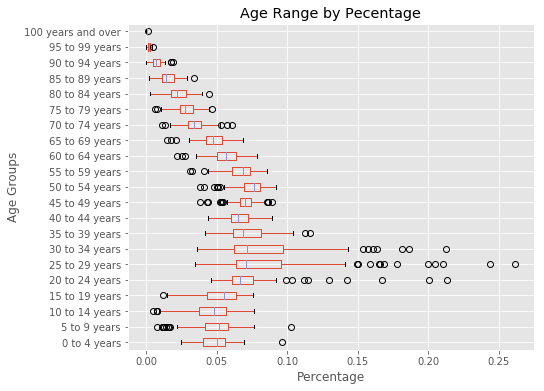

In [19]:
fig = plt.figure()

#ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

#age_df.plot(kind='box', figsize=(16, 6), vert=False, ax=ax0)
#ax0.set_title('Age Range by Raw Numbers')
#ax0.set_xlabel('Count')
#ax0.set_ylabel('Age Groups')


agepct_df.plot(kind='box', figsize=(16, 6), vert=False, ax=ax1)
ax1.set_title('Age Range by Pecentage')
ax1.set_xlabel('Percentage')
ax1.set_ylabel('Age Groups')

plt.show()

#### Age Range (25 - 29 years)

The age range of '25 - 29 years' has many outliers.  Unsurpringly, much of this is concentrated in the downtown area.

In [20]:
agepct_choropleth = map_toronto_choropleth (agepct_df.reset_index(), '25 to 29 years')
agepct_choropleth

### 6.2 Household After-Tax Income Dataset

Similar to the age groups, build a dataframe grouping by percentage

In [21]:
hh_income_cols = [
    'Household after-tax income <$5000', 
    'Household after-tax income \$5000-$9999', 
    'Household after-tax income \$10000-$14999', 
    'Household after-tax income \$15000-$19999', 
    'Household after-tax income \$20000-$24999', 
    'Household after-tax income \$25000-$29999', 
    'Household after-tax income \$30000-$34999', 
    'Household after-tax income \$35000-$39999', 
    'Household after-tax income \$40000-$44999', 
    'Household after-tax income \$45000-$49999', 
    'Household after-tax income \$50000-$59999', 
    'Household after-tax income \$60000-$69999', 
    'Household after-tax income \$70000-$79999', 
    'Household after-tax income \$80000-$89999', 
    'Household after-tax income \$90000-$99999', 
    'Household after-tax income \$100000-$124999', 
    'Household after-tax income \$125000-$149999',
    'Household after-tax income $150000+']
    
hh_income_df = toronto_data_indexed_df[hh_income_cols]

# convert the age ranges to percentages for a better comparison
hh_incomepct_df = toronto_data_indexed_df[hh_income_cols]
hh_incomepct_df[hh_income_cols] = hh_incomepct_df[hh_income_cols].div(hh_incomepct_df[hh_income_cols].sum(axis=1), axis=0)
hh_incomepct_df.head()


Household after-tax income <$5000  \
Postal Code                                      
M3A                                   0.026455   
M4A                                   0.023520   
M5A                                   0.037609   
M6A                                   0.024768   
M9A                                   0.022149   

             Household after-tax income \$5000-$9999  \
Postal Code                                            
M3A                                         0.013983   
M4A                                         0.027575   
M5A                                         0.051936   
M6A                                         0.021053   
M9A                                         0.014876   

             Household after-tax income \$10000-$14999  \
Postal Code                                              
M3A                                           0.024943   
M4A                                           0.038929   
M5A                                           0.076114   
M6A                                           0.038390   
M9A                                           0.025455   

             Household after-tax income \$15000-$19999  \
Postal Code                                              
M3A                                           0.038927   
M4A                                           0.071371   
M5A                                           0.073875   
M6A                                           0.077399   
M9A                                           0.045289   

             Household after-tax income \$20000-$24999  \
Postal Code                                              
M3A                                           0.049887   
M4A                                           0.057583   
M5A                                           0.054399   
M6A                                           0.066254   
M9A                                           0.039339   

             Household after-tax income \$25000-$29999  \
Postal Code                                              
M3A                                           0.046485   
M4A                                           0.054339   
M5A                                           0.049026   
M6A                                           0.053870   
M9A                                           0.040000   

             Household after-tax income \$30000-$34999  \
Postal Code                                              
M3A                                           0.051020   
M4A                                           0.055150   
M5A                                           0.044773   
M6A                                           0.059443   
M9A                                           0.040331   

             Household after-tax income \$35000-$39999  \
Postal Code                                              
M3A                                           0.054044   
M4A                                           0.058394   
M5A                                           0.048578   
M6A                                           0.055728   
M9A                                           0.044959   

             Household after-tax income \$40000-$44999  \
Postal Code                                              
M3A                                           0.056689   
M4A                                           0.062449   
M5A                                           0.045892   
M6A                                           0.055108   
M9A                                           0.047273   

             Household after-tax income \$45000-$49999  \
Postal Code                                              
M3A                                           0.059713   
M4A                                           0.057583   
M5A                                           0.045444   
M6A                                           0.058824   
M9A                                           0.047603   

             

### Visualize Household Income Data

#### Household Income by Percentage

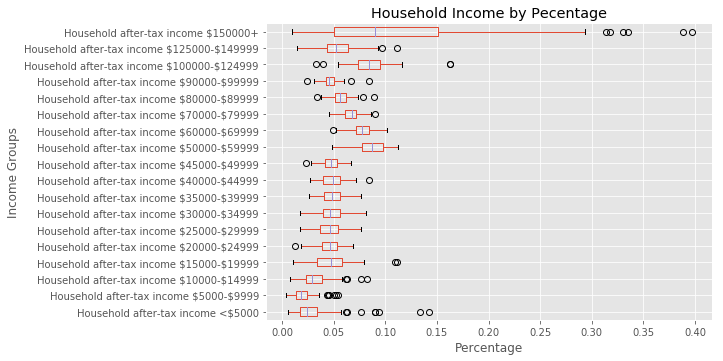

In [22]:
fig = plt.figure()

ax1 = fig.add_subplot(2, 1, 2)

hh_incomepct_df.plot(kind='box', figsize=(8, 12), vert=False, ax=ax1)
ax1.set_title('Household Income by Pecentage')
ax1.set_xlabel('Percentage')
ax1.set_ylabel('Income Groups')

plt.show()

#### Household Income over $150,000

The household income range over $150,000 has quite a wide range.  Let's visualize this grouping.


In [23]:
hhincomepct_choropleth = map_toronto_choropleth (hh_incomepct_df.reset_index(), 'Household after-tax income $150000+')
hhincomepct_choropleth

### 6.3 Family Type Distribution

Lastly, get a dataframe of the family breakdown by percentage

In [24]:
family_cols = ['Couple families with no children',
                 'Couple families with 1 child',
                 'Couple families with 2 children',
                 'Couple families with 3+ children',
                 'Single parent with 1 child', 
                 'Single parent with 2 children',
                 'Single parent with 3+ children', 
                 'Number of singles']

    
    
family_df = toronto_data_indexed_df[family_cols]

# convert the family data ranges to percentages for a better comparison
familypct_df = toronto_data_indexed_df[family_cols]
familypct_df[family_cols] = familypct_df[family_cols].div(familypct_df[family_cols].sum(axis=1), axis=0)
familypct_df.head()



Couple families with no children  Couple families with 1 child  \
Postal Code                                                                   
M3A                                  0.173021                      0.115999   
M4A                                  0.169540                      0.101293   
M5A                                  0.181637                      0.042116   
M6A                                  0.142632                      0.088096   
M9A                                  0.227531                      0.103912   

             Couple families with 2 children  \
Postal Code                                    
M3A                                 0.122515   
M4A                                 0.094828   
M5A                                 0.026747   
M6A                                 0.066072   
M9A                                 0.110182   

             Couple families with 3+ children  Single parent with 1 child  \
Postal Code                                                                 
M3A                                  0.050179                    0.096774   
M4A                                  0.032328                    0.102011   
M5A                                  0.018762                    0.047705   
M6A                                  0.055585                    0.094389   
M9A                                  0.038519                    0.068379   

             Single parent with 2 children  Single parent with 3+ children  \
Postal Code                                                                  
M3A                               0.046269                        0.021180   
M4A                               0.036638                        0.015805   
M5A                               0.019760                        0.011178   
M6A                               0.046146                        0.033561   
M9A                               0.029262                        0.009256   

             Number of singles  
Postal Code                     
M3A                   0.374063  
M4A                   0.447557  
M5A                   0.652096  
M6A                   0.473519  
M9A                   0.412959

### Visualize Family Dataset

#### Family Type by Percentage

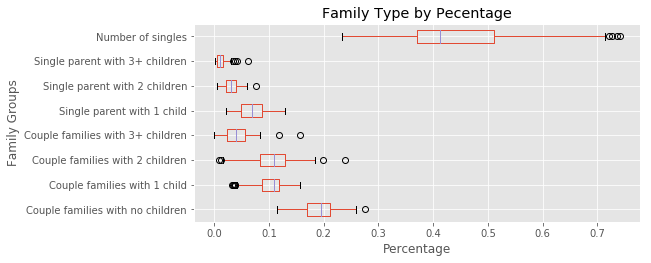

In [102]:
fig = plt.figure()

ax1 = fig.add_subplot(2, 1, 2)

familypct_df.plot(kind='box', figsize=(8, 8), vert=False, ax=ax1)
ax1.set_title('Family Type by Pecentage')
ax1.set_xlabel('Percentage')
ax1.set_ylabel('Family Groups')

plt.show()

#### Concentration of Singles "Families"

Visualize where all the single "families" are.


In [26]:
familypct_choropleth = map_toronto_choropleth (familypct_df.reset_index(), 'Number of singles')
familypct_choropleth

###  6.4 Merging Age, Household Income, and Family Type into One Dataset

Merge the datasets of the percentage of each age, income, and family datasets.  This will be used to group neighbourhoods with similar census characteristics.

In [27]:
toronto_mergedpct = agepct_df.merge(hh_incomepct_df.merge(familypct_df, on='Postal Code'), on='Postal Code')
toronto_mergedpct.head()

0 to 4 years  5 to 9 years  10 to 14 years  15 to 19 years  \
Postal Code                                                               
M3A              0.051871      0.057073        0.058951        0.065597   
M4A              0.046431      0.049550        0.045045        0.053015   
M5A              0.037858      0.031163        0.028850        0.036275   
M6A              0.056478      0.062174        0.063598        0.071191   
M9A              0.040320      0.044114        0.049312        0.054931   

             20 to 24 years  25 to 29 years  30 to 34 years  35 to 39 years  \
Postal Code                                                                   
M3A                0.068343        0.067042        0.065020        0.067620   
M4A                0.059598        0.062370        0.062370        0.070686   
M5A                0.076446        0.121972        0.126111        0.094827   
M6A                0.066208        0.057665        0.064072        0.073564   
M9A                0.065187        0.073757        0.069402        0.064203   

             40 to 44 years  45 to 49 years  50 to 54 years  55 to 59 years  \
Postal Code                                                                   
M3A                0.069643        0.073978        0.080913        0.069499   
M4A                0.061331        0.069647        0.076230        0.071379   
M5A                0.074985        0.076689        0.076324        0.063055   
M6A                0.066445        0.065733        0.066682        0.058614   
M9A                0.061394        0.069682        0.076847        0.074740   

             60 to 64 years  65 to 69 years  70 to 74 years  75 to 79 years  \
Postal Code                                                                   
M3A                0.053460        0.043924        0.034533        0.027453   
M4A                0.064449        0.053361        0.042966        0.042273   
M5A                0.054291        0.041996        0.026172        0.015581   
M6A                0.050783        0.042952        0.032036        0.029188   
M9A                0.065889        0.053948        0.037932        0.031329   

             80 to 84 years  85 to 89 years  90 to 94 years  95 to 99 years  \
Postal Code                                                                   
M3A                0.023118        0.015460        0.005346        0.001011   
M4A                0.032571        0.020790        0.012474        0.003119   
M5A                0.009495        0.005113        0.002069        0.000609   
M6A                0.028477        0.021120        0.017561        0.004983   
M9A                0.028519        0.021776        0.013065        0.003091   

             100 years and over  Household after-tax income <$5000  \
Postal Code                                                          
M3A                    0.000144                           0.026455   
M4A                    0.000347                           0.023520   
M5A                    0.000122                           0.037609   
M6A                    0.000475                           0.024768   
M9A                    0.000562                           0.022149   

             Household after-tax income \$5000-$9999  \
Postal Code                                            
M3A                                         0.013983   
M4A                                         0.027575   
M5A                                         0.051936   
M6A                                         0.021053   
M9A                                         0.014876   

             Household after-tax income \$10000-$14999  \
Postal Code                                              
M3A                                           0.024943   
M4A                                           0.038929   
M5A                                           0.076114   
M6A                                           0.038390   
M9A                                    

## 7.  Build Neighbourhood Clusters and Get Top Venues by Cluster

The 96 postal areas will be grouped into 6 clusters.

In [28]:
kclusters = 6

kmeans_mergedpct = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_mergedpct)

In [29]:
toronto_mergedpct_df = toronto_coords_df.merge(toronto_mergedpct, on='Postal Code').set_index('Postal Code')
toronto_mergedpct_df.insert(0, 'Cluster Labels', kmeans_mergedpct.labels_)

In [30]:
map_clusters = map_toronto_clusters (kclusters, toronto_mergedpct_df)
map_clusters

In [55]:
def getTopVenuesbyCluster (cluster_label, full_df):
    
    cluster_df = full_df[full_df['Cluster Labels']==cluster_label]
    print ('The number of postal areas in {} is {}'.format(cluster_label, cluster_df.shape[0]))
    
    cluster_venues = getNearbyVenues(names=cluster_df['Neighborhood'], 
                                     latitudes=cluster_df['Latitude'],
                                     longitudes=cluster_df['Longitude'],
                                     radius = 2500,
                                     limit = 100)
    
    cluster_onehot = pd.get_dummies(cluster_venues[['Venue Category']], prefix="", prefix_sep="")
    
    # add neighborhood column back to dataframe
    cluster_onehot['Neighborhood'] = cluster_venues['Neighborhood'] 

    # move neighborhood column to the first column
    fixed_columns = [cluster_onehot.columns[-1]] + list(cluster_onehot.columns[:-1])
    cluster_onehot = cluster_onehot[fixed_columns]

    cluster_grouped = cluster_onehot.groupby('Neighborhood').mean().reset_index()
    
    # Organize by the top venues
    num_top_venues = 10
    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Neighborhood']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    cluster_venues_sorted = pd.DataFrame(columns=columns)
    cluster_venues_sorted['Neighborhood'] = cluster_grouped['Neighborhood']

    for ind in np.arange(cluster_grouped.shape[0]):
        cluster_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cluster_grouped.iloc[ind, :], num_top_venues)

    return cluster_venues_sorted

### 7.1 Cluster 0

Obtain the top 10 venues for cluster 0

In [87]:
cluster0_df = toronto_mergedpct_df[toronto_mergedpct_df['Cluster Labels']==0]


In [56]:
cluster0_venues = getTopVenuesbyCluster (0, toronto_mergedpct_df)
cluster0_venues

The number of postal areas in 0 is 15


Neighborhood 1st Most Common Venue  \
0                                            Christie                  Café   
1                                          Davisville           Coffee Shop   
2                        Dufferin, Dovercourt Village                  Café   
3                 Forest Hill West, Forest Hill North                  Café   
4                                  Humewood-Cedarvale           Coffee Shop   
5        New Toronto, Mimico South, Humber Bay Shores           Coffee Shop   
6                        Riverdale, The Danforth West      Greek Restaurant   
7                              Roncesvalles, Parkdale           Coffee Shop   
8                                            Rosedale           Coffee Shop   
9                                     Studio District           Coffee Shop   
10                        Summerhill East, Moore Park    Italian Restaurant   
11  Summerhill West, South Hill, Rathnelly, Forest...    Italian Restaurant   
12  Sunnylea, Royal York South East, The Queensway...           Coffee Shop   
13                      The Junction South, High Park                  Café   
14                                   Willowdale South     Korean Restaurant   

   2nd Most Common Venue 3rd Most Common Venue          4th Most Common Venue  \
0            Coffee Shop     Korean Restaurant  Vegetarian / Vegan Restaurant   
1                   Café    Italian Restaurant                           Park   
2                    Bar    Italian Restaurant                    Coffee Shop   
3            Coffee Shop    Italian Restaurant                           Park   
4     Italian Restaurant                  Café                         Bakery   
5                   Park           Pizza Place               Sushi Restaurant   
6                   Café                  Park                         Bakery   
7                   Café                  Park                            Bar   
8     Italian Restaurant                  Park                            Spa   
9                   Park                  Café          Vietnamese Restaurant   
10                  Park                  Café                    Coffee Shop   
11                  Café                  Park                    Coffee Shop   
12                Bakery    Italian Restaurant               Sushi Restaurant   
13           Coffee Shop                   Bar             Italian Restaurant   
14           Coffee Shop                  Café                  Burrito Place   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0                     Bar     Indian Restaurant              Beer Bar   
1                     Gym                Bakery             Gastropub   
2                    Park                Bakery               Brewery   
3          Ice Cream Shop             Gastropub          Dessert Shop   
4     Japanese Restaurant        Breakfast Spot  Caribbean Restaurant   
5          Sandwich Place            Restaurant  Fast Food Restaurant   
6   Vietnamese Restaurant           Coffee Shop    Italian Restaurant   
7                  Bakery            Restaurant    Italian Restaurant   
8              Restaurant             Gastropub   Japanese Restaurant   
9                 Brewery                   Bar                Bakery   
10                    Spa         Grocery Store          Dessert Shop   
11         Ice Cream Shop                   Spa     French Restaurant   
12                   Café            Restaurant                  Park   
13                 Bakery           Pizza Place               Brewery   
14    Fried Chicken Joint                  Park      Sushi Restaurant   

            8th Most Common Venue 9th Most Common Venue  \
0                     Pizza Place           Comedy Club   
1                Sushi Restaurant           Pizza Place   
2                    Cocktail Bar        Breakfast Spot   
3       Middle Eastern Restaurant                Bakery   
4              

###  7.2 Cluster 1

Obtain the top 10 venues for cluster 0


In [88]:
cluster1_df = toronto_mergedpct_df[toronto_mergedpct_df['Cluster Labels']==1]

In [58]:
cluster1_venues = getTopVenuesbyCluster (1, toronto_mergedpct_df)
cluster1_venues

The number of postal areas in 1 is 37


Neighborhood  \
0                                           Agincourt   
1                                 Caledonia-Fairbanks   
2                                           Cedarbrae   
3                    Don Mills South, Flemingdon Park   
4                                   Downsview Central   
5                         Downsview East, CFB Toronto   
6                                 Downsview Northwest   
7                                      Downsview West   
8                                       Humber Summit   
9                                    Humberlea, Emery   
10        Kennedy Park, Ionview, East Birchmount Park   
11                                    L'Amoreaux West   
12                   Lawrence Manor, Lawrence Heights   
13                                     Malvern, Rouge   
14                                          Northwest   
15                    Oakridge, Golden Mile, Clairlea   
16                       Oriole, Henry Farm, Fairview   
17                    Parkview Hill, Woodbine Gardens   
18                                          Parkwoods   
19                      Runnymede, The Junction North   
20                                Scarborough Village   
21     Silverthorn, Mount Dennis, Keelesdale, Del Ray   
22  St. Phillips, Richview Gardens, Martin Grove G...   
23  Steeles East, Milliken, L'Amoreaux East, Aginc...   
24            Tam O'Shanter, Sullivan, Clarks Corners   
25  Thistletown, South Steeles, Silverstone, Mount...   
26                                   Thorncliffe Park   
27                 Upwood Park, North Park, Downsview   
28                                   Victoria Village   
29                  West Hill, Morningside, Guildwood   
30                                             Weston   
31  Wexford Heights, Scarborough Town Centre, Dors...   
32                                  Wexford, Maryvale   
33                                    Willowdale West   
34                                             Woburn   
35                                   Woodbine Heights   
36                    York University, Northwood Park   

        1st Most Common Venue      2nd Most Common Venue  \
0          Chinese Restaurant             Clothing Store   
1          Italian Restaurant                Coffee Shop   
2                 Coffee Shop             Clothing Store   
3                 Coffee Shop        Japanese Restaurant   
4                 Coffee Shop      Vietnamese Restaurant   
5              Clothing Store                Coffee Shop   
6                 Coffee Shop       Fast Food Restaurant   
7                 Coffee Shop      Vietnamese Restaurant   
8                 Coffee Shop       Fast Food Restaurant   
9        Fast Food Restaurant                Coffee Shop   
10             Sandwich Place                Coffee Shop   
11         Chinese Restaurant               Dessert Shop   
12             Clothing Store                Coffee Shop   
13                Zoo Exhibit       Fast Food Restaurant   
14                      Hotel                Coffee Shop   
15                Coffee Shop             Sandwich Place   
16                Coffee Shop         Chinese Restaurant   
17                Coffee Shop       Fast Food Restaurant   
18                Coffee Shop  Middle Eastern Restaurant   
19                Coffee Shop                       Café   
20       Fast Food Restaurant                Coffee Shop   
21                Coffee Shop             Sandwich Place   
22                Coffee Shop                Pizza Place   
23         Chinese Restaurant                Coffee Shop   
24         Chinese Restaurant                Coffee Shop   
25                Coffee Shop          Indian Restaurant   
26                Coffee Shop              Grocery Store   
27                Coffee Shop             Sandwich Place   
28  Middle Eastern Restaurant               Burger Joint   
29                Pizza Place                Coffee Shop   
30            

###  7.3 Cluster 2

Obtain the top 10 venues for cluster 2

In [89]:
cluster2_df = toronto_mergedpct_df[toronto_mergedpct_df['Cluster Labels']==2]

In [60]:
cluster2_venues = getTopVenuesbyCluster (2, toronto_mergedpct_df)
cluster2_venues

The number of postal areas in 2 is 10


Neighborhood 1st Most Common Venue  \
0                                Don Mills North           Coffee Shop   
1              Lawrence Manor East, Bedford Park           Coffee Shop   
2                                  Lawrence Park           Coffee Shop   
3                                        Leaside           Coffee Shop   
4                             North Toronto West           Coffee Shop   
5  Old Mill North, Montgomery Road, The Kingsway           Coffee Shop   
6         Port Union, Rouge Hill, Highland Creek           Coffee Shop   
7                                       Roselawn           Coffee Shop   
8                                York Mills West           Coffee Shop   
9                       York Mills, Silver Hills           Coffee Shop   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0   Japanese Restaurant    Italian Restaurant            Restaurant   
1            Bagel Shop                  Café      Sushi Restaurant   
2    Italian Restaurant                Bakery      Sushi Restaurant   
3     Indian Restaurant                  Park         Grocery Store   
4                  Café    Italian Restaurant                Bakery   
5                Bakery    Italian Restaurant      Sushi Restaurant   
6                  Park        Sandwich Place         Grocery Store   
7    Italian Restaurant                  Café                Bakery   
8   Japanese Restaurant                Bakery                  Café   
9                  Bank          Burger Joint              Pharmacy   

  5th Most Common Venue 6th Most Common Venue      7th Most Common Venue  \
0                  Park           Pizza Place                Supermarket   
1                Bakery        Sandwich Place                Pizza Place   
2                  Café              Tea Room                       Park   
3                Bakery            Restaurant                       Café   
4      Sushi Restaurant                  Park                  Gastropub   
5                  Café                   Pub            Thai Restaurant   
6        Breakfast Spot          Burger Joint                   Pharmacy   
7                 Trail                  Park  Middle Eastern Restaurant   
8          Burger Joint         Grocery Store                 Restaurant   
9    Italian Restaurant   Japanese Restaurant         Chinese Restaurant   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0          Burger Joint                  Bank               Pharmacy  
1                  Bank              Pharmacy           Burger Joint  
2   Japanese Restaurant                 Diner         Ice Cream Shop  
3   Japanese Restaurant      Sushi Restaurant            Pizza Place  
4   Japanese Restaurant          Burger Joint          Grocery Store  
5                  Bank           Pizza Place           Burger Joint  
6                   Gym          Liquor Store   Fast Food Restaurant  
7            Bagel Shop   Japanese Restaurant              Gastropub  
8      Sushi Restaurant              Pharmacy             Steakhouse  
9           Supermarket        Sandwich Place         Breakfast Spot

###  7.4 Cluster 3

Obtain the top 10 venues for cluster 4

In [90]:
cluster3_df = toronto_mergedpct_df[toronto_mergedpct_df['Cluster Labels']==3]

In [63]:
cluster3_venues = getTopVenuesbyCluster (3, toronto_mergedpct_df)
cluster3_venues

The number of postal areas in 3 is 18


Neighborhood 1st Most Common Venue  \
0                                     Bayview Village           Coffee Shop   
1                         Cliffside West, Birch Cliff           Coffee Shop   
2                                        East Toronto      Greek Restaurant   
3                                           Glencairn        Clothing Store   
4                                   Hillcrest Village                Bakery   
5                      India Bazaar, The Beaches West           Coffee Shop   
6                                    Islington Avenue           Pizza Place   
7                              Long Branch, Alderwood           Coffee Shop   
8   Old Burnhamthorpe, Markland Wood, Eringate, Bl...           Coffee Shop   
9     Scarborough Village West, Cliffside, Cliffcrest                  Park   
10  South of Bloor, Royal York South West, The Que...           Coffee Shop   
11                                 Swansea, Runnymede    Italian Restaurant   
12                                        The Beaches                   Pub   
13                                        Upper Rouge           Zoo Exhibit   
14  West Deane Park, Princess Gardens, Martin Grov...           Coffee Shop   
15                                          Westmount           Coffee Shop   
16                            Willowdale, Newtonbrook     Korean Restaurant   
17    Wilson Heights, Downsview North, Bathurst Manor           Coffee Shop   

   2nd Most Common Venue   3rd Most Common Venue      4th Most Common Venue  \
0     Chinese Restaurant                Pharmacy                       Bank   
1          Grocery Store                    Park                     Bakery   
2                   Café                    Park                     Bakery   
3            Coffee Shop  Furniture / Home Store                 Bagel Shop   
4            Coffee Shop     Japanese Restaurant         Chinese Restaurant   
5                  Beach                    Park                       Café   
6            Coffee Shop             Golf Course                   Pharmacy   
7   Fast Food Restaurant             Pizza Place                 Restaurant   
8                   Bank                Pharmacy                      Hotel   
9   Fast Food Restaurant                Pharmacy              Grocery Store   
10          Burger Joint        Sushi Restaurant             Breakfast Spot   
11           Coffee Shop                  Bakery                        Bar   
12                 Beach             Coffee Shop                       Café   
13                  Park              Restaurant               Dessert Shop   
14        Sandwich Place    Fast Food Restaurant                       Bank   
15           Pizza Place          Sandwich Place              Grocery Store   
16           Coffee Shop                    Café  Middle Eastern Restaurant   
17        Sandwich Place             Pizza Place                       Park   

   5th Most Common Venue   6th Most Common Venue 7th Most Common Venue  \
0          Shopping Mall                    Café           Pizza Place   
1         Sandwich Place                     Pub          Burger Joint   
2    American Restaurant               Gastropub           Pizza Place   
3                 Bakery                Boutique        Chocolate Shop   
4                   Park        Asian Restaurant        Sandwich Place   
5                Brewery                  Bakery             Gastropub   
6                   Park                    Bank                Bakery   
7         Sandwich Place  Furniture / Home Store                Bakery   
8         Sandwich Place                     Pub         Grocery Store   
9         Sandwich Place             Coffee Shop           Pizza Place   
10            Restaurant      Italian Restaurant                Bakery   
11                  Café        Sushi Restaurant             Gastropub   
12                  Park          Breakfast Spot                Bakery   
1

###  7.5 Cluster 4

Obtain the top 10 venues for cluster 4

In [91]:
cluster4_df = toronto_mergedpct_df[toronto_mergedpct_df['Cluster Labels']==4]

In [65]:
cluster4_venues = getTopVenuesbyCluster (4, toronto_mergedpct_df)
cluster4_venues

The number of postal areas in 4 is 5


Neighborhood 1st Most Common Venue  \
0                         Central Bay Street                  Café   
1                       Church and Wellesley   Japanese Restaurant   
2                   Garden District, Ryerson           Coffee Shop   
3  Kensington Market, Grange Park, Chinatown                  Café   
4             University of Toronto, Harbord                  Café   

  2nd Most Common Venue 3rd Most Common Venue          4th Most Common Venue  \
0           Coffee Shop           Pizza Place                        Theater   
1           Coffee Shop                  Park                    Pizza Place   
2                 Hotel                  Café            Japanese Restaurant   
3           Coffee Shop           Pizza Place                 Sandwich Place   
4           Coffee Shop        Sandwich Place  Vegetarian / Vegan Restaurant   

  5th Most Common Venue 6th Most Common Venue          7th Most Common Venue  \
0          Concert Hall            Restaurant  Vegetarian / Vegan Restaurant   
1            Restaurant       Thai Restaurant             Italian Restaurant   
2               Theater       Thai Restaurant                     Steakhouse   
3    Italian Restaurant                   Bar                         Bakery   
4                   Bar          Cocktail Bar                    Pizza Place   

           8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0                      Gastropub                   Gym             Steakhouse  
1  Vegetarian / Vegan Restaurant      Ramen Restaurant                  Diner  
2                 Farmers Market           Pizza Place              Gastropub  
3  Vegetarian / Vegan Restaurant          Cocktail Bar               Beer Bar  
4             Italian Restaurant                  Park       Ramen Restaurant

###  7.6 Cluster 5

Obtain the top 10 venues for cluster 5

In [92]:
cluster5_df = toronto_mergedpct_df[toronto_mergedpct_df['Cluster Labels']==5]

In [103]:
cluster5_venues = getTopVenuesbyCluster (5, toronto_mergedpct_df)
cluster5_venues

The number of postal areas in 5 is 11


Neighborhood 1st Most Common Venue  \
0                                         Berczy Park           Coffee Shop   
1                                    Davisville North           Coffee Shop   
2        Parkdale Village, Exhibition Place, Brockton                  Café   
3                           Regent Park, Harbourfront           Coffee Shop   
4                            Richmond, King, Adelaide           Coffee Shop   
5   South Niagara, Railway Lands, King and Spadina...                  Park   
6                                      St. James Town           Coffee Shop   
7                         St. James Town, Cabbagetown           Coffee Shop   
8                            Trinity, Little Portugal                  Café   
9   Union Station, Toronto Islands, Harbourfront East           Coffee Shop   
10                Yorkville, North Midtown, The Annex           Coffee Shop   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                   Café                 Hotel    Italian Restaurant   
1                   Café                Bakery    Italian Restaurant   
2                    Bar            Restaurant    Italian Restaurant   
3                   Park                  Café   Japanese Restaurant   
4                  Hotel                  Café               Theater   
5     Italian Restaurant           Coffee Shop                 Hotel   
6                   Café                 Hotel               Theater   
7                   Park    Italian Restaurant             Gastropub   
8                    Bar          Cocktail Bar                Bakery   
9                   Café                 Hotel                  Park   
10    Italian Restaurant                  Café                   Spa   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0                Theater                  Park        Cosmetics Shop   
1                   Park   Sporting Goods Shop                   Gym   
2            Coffee Shop                Bakery    Athletics & Sports   
3                  Diner            Restaurant             Gastropub   
4             Restaurant           Pizza Place                   Gym   
5                 Bakery                   Gym                  Café   
6        Thai Restaurant   Japanese Restaurant        Farmers Market   
7                  Diner            Restaurant                  Café   
8     Italian Restaurant           Pizza Place      Asian Restaurant   
9               Beer Bar                   Gym               Theater   
10                  Park        Ice Cream Shop     Korean Restaurant   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0         Farmers Market                Bakery    Japanese Restaurant  
1    Japanese Restaurant             Gastropub           Burger Joint  
2       Asian Restaurant          Cocktail Bar    Arts & Crafts Store  
3         Farmers Market    Italian Restaurant                    Bar  
4    Japanese Restaurant          Concert Hall                  Diner  
5    Japanese Restaurant           Music Venue                Brewery  
6    Monument / Landmark            Restaurant                    Gym  
7        Thai Restaurant   Japanese Restaurant       Ramen Restaurant  
8            Coffee Shop           Yoga Studio                    Gym  
9    Japanese Restaurant    Italian Restaurant            Pizza Place  
10   Japanese Restaurant         Grocery Store              Bookstore

## 8.  Compare Neighbourhood Clusters

### 8.1 Age

Clusters 4 and 5 have a high percentage of habitants in the 20 - 35 age range.

Clusters 0, 1, 2, 3 share a similar distribution for age ranges


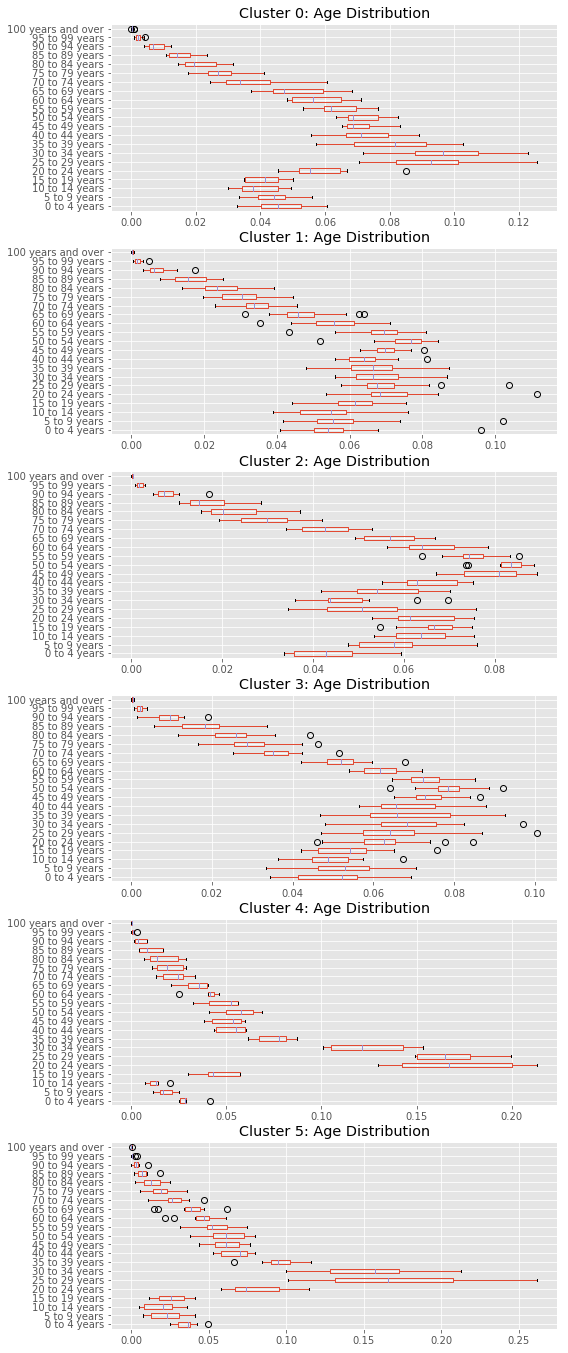

In [96]:
cluster0_age = cluster0_df[age_cols]
cluster1_age = cluster1_df[age_cols]
cluster2_age = cluster2_df[age_cols]
cluster3_age = cluster3_df[age_cols]
cluster4_age = cluster4_df[age_cols]
cluster5_age = cluster5_df[age_cols]

fig = plt.figure()

ax0 = fig.add_subplot(6, 1, 1)
ax1 = fig.add_subplot(6, 1, 2)
ax2 = fig.add_subplot(6, 1, 3)
ax3 = fig.add_subplot(6, 1, 4)
ax4 = fig.add_subplot(6, 1, 5)
ax5 = fig.add_subplot(6, 1, 6)

cluster0_age.plot(kind='box', figsize=(8, 24), vert=False, ax=ax0)
cluster1_age.plot(kind='box', figsize=(8, 24), vert=False, ax=ax1)
cluster2_age.plot(kind='box', figsize=(8, 24), vert=False, ax=ax2)
cluster3_age.plot(kind='box', figsize=(8, 24), vert=False, ax=ax3)
cluster4_age.plot(kind='box', figsize=(8, 24), vert=False, ax=ax4)
cluster5_age.plot(kind='box', figsize=(8, 24), vert=False, ax=ax5)

ax0.set_title('Cluster 0: Age Distribution')
ax1.set_title('Cluster 1: Age Distribution')
ax2.set_title('Cluster 2: Age Distribution')
ax3.set_title('Cluster 3: Age Distribution')
ax4.set_title('Cluster 4: Age Distribution')
ax5.set_title('Cluster 5: Age Distribution')

plt.show()

### 8.2 Household Income

Clusters 0 and 2 have a very high percentage of household incomes over $150,000 as compared to the other clusters.

On the other hand Cluster 4 has a high percentage of household incomes under $5,000.

Clusters 1, 3, and 5 share a similar household income pattern, which is more distributed.

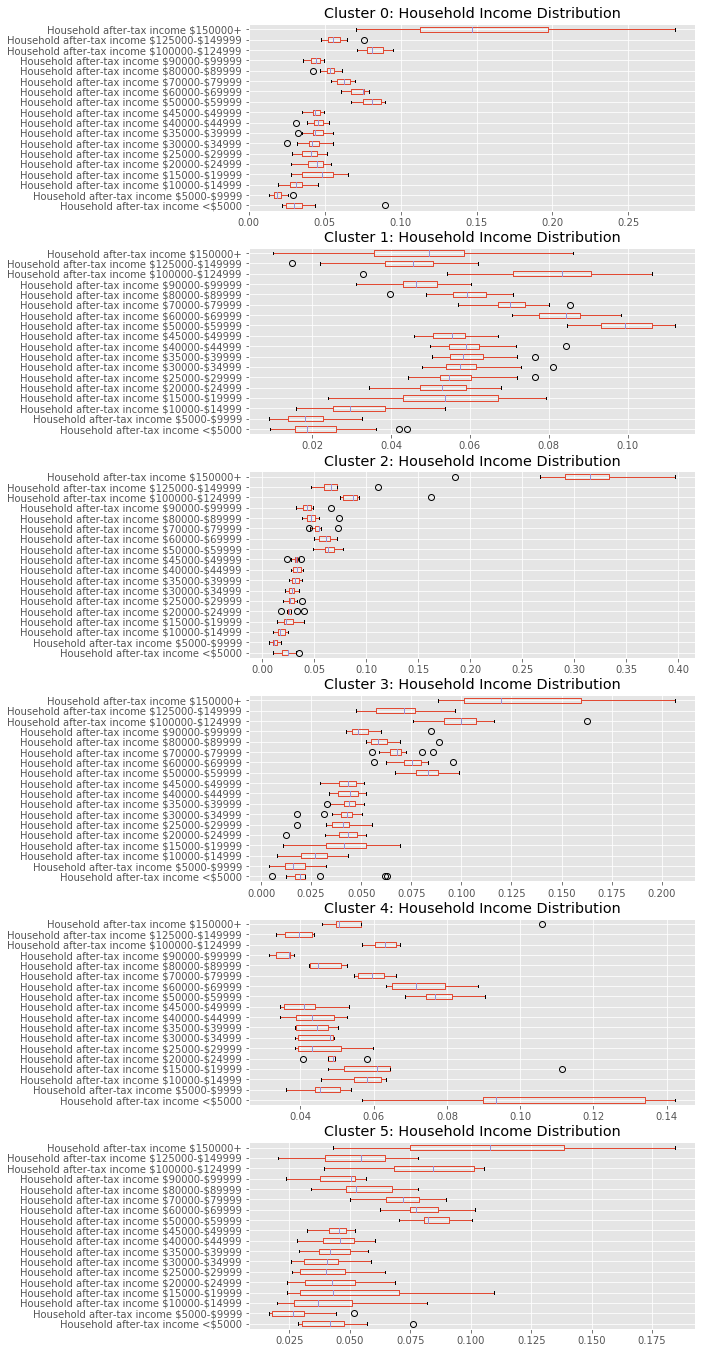

In [97]:
cluster0_income = cluster0_df[hh_income_cols]
cluster1_income = cluster1_df[hh_income_cols]
cluster2_income = cluster2_df[hh_income_cols]
cluster3_income = cluster3_df[hh_income_cols]
cluster4_income = cluster4_df[hh_income_cols]
cluster5_income = cluster5_df[hh_income_cols]

fig = plt.figure()

ax0 = fig.add_subplot(6, 1, 1)
ax1 = fig.add_subplot(6, 1, 2)
ax2 = fig.add_subplot(6, 1, 3)
ax3 = fig.add_subplot(6, 1, 4)
ax4 = fig.add_subplot(6, 1, 5)
ax5 = fig.add_subplot(6, 1, 6)

cluster0_income.plot(kind='box', figsize=(8, 24), vert=False, ax=ax0)
cluster1_income.plot(kind='box', figsize=(8, 24), vert=False, ax=ax1)
cluster2_income.plot(kind='box', figsize=(8, 24), vert=False, ax=ax2)
cluster3_income.plot(kind='box', figsize=(8, 24), vert=False, ax=ax3)
cluster4_income.plot(kind='box', figsize=(8, 24), vert=False, ax=ax4)
cluster5_income.plot(kind='box', figsize=(8, 24), vert=False, ax=ax5)

ax0.set_title('Cluster 0: Household Income Distribution')
ax1.set_title('Cluster 1: Household Income Distribution')
ax2.set_title('Cluster 2: Household Income Distribution')
ax3.set_title('Cluster 3: Household Income Distribution')
ax4.set_title('Cluster 4: Household Income Distribution')
ax5.set_title('Cluster 5: Household Income Distribution')

plt.show()

### 8.3 Family Breakdown

Clusters 0, 4, and 5 are mostly singles and families without children.

Clusters 1, 2, and 3 have a higher relative percentage of families with children.


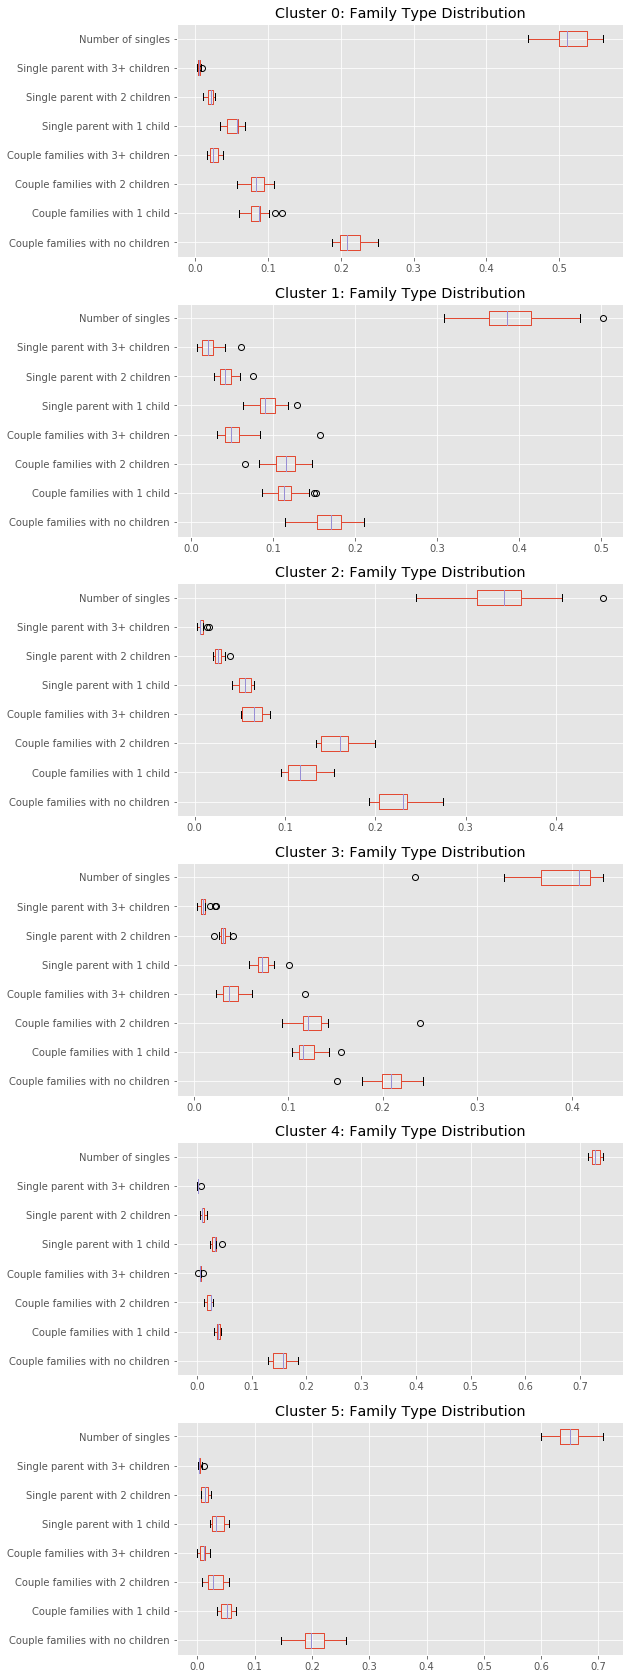

In [100]:
cluster0_family = cluster0_df[family_cols]
cluster1_family = cluster1_df[family_cols]
cluster2_family = cluster2_df[family_cols]
cluster3_family = cluster3_df[family_cols]
cluster4_family = cluster4_df[family_cols]
cluster5_family = cluster5_df[family_cols]

fig = plt.figure()

ax0 = fig.add_subplot(6, 1, 1)
ax1 = fig.add_subplot(6, 1, 2)
ax2 = fig.add_subplot(6, 1, 3)
ax3 = fig.add_subplot(6, 1, 4)
ax4 = fig.add_subplot(6, 1, 5)
ax5 = fig.add_subplot(6, 1, 6)

cluster0_family.plot(kind='box', figsize=(8, 30), vert=False, ax=ax0)
cluster1_family.plot(kind='box', figsize=(8, 30), vert=False, ax=ax1)
cluster2_family.plot(kind='box', figsize=(8, 30), vert=False, ax=ax2)
cluster3_family.plot(kind='box', figsize=(8, 30), vert=False, ax=ax3)
cluster4_family.plot(kind='box', figsize=(8, 30), vert=False, ax=ax4)
cluster5_family.plot(kind='box', figsize=(8, 30), vert=False, ax=ax5)

ax0.set_title('Cluster 0: Family Type Distribution')
ax1.set_title('Cluster 1: Family Type Distribution')
ax2.set_title('Cluster 2: Family Type Distribution')
ax3.set_title('Cluster 3: Family Type Distribution')
ax4.set_title('Cluster 4: Family Type Distribution')
ax5.set_title('Cluster 5: Family Type Distribution')

plt.show()


## 9. Cluster Comparison Summary

<b> Cluster 0 </b>
* Geography: Toronto surroundings 
* FSA/postal codes: 15
* Age distribution: Relatively typical
* Household income distribution: High percentage $150,000 and over
* Family Type: High number of singles and families without children.
* 11 out of 15 neighbourhoods have Italian restaurants as a top 10 venue
* 8 of the 15 are in the top 3
* Italian restaurants not in the top 10 venues are Christie, Mimico South, Willowdale South, and Studio District.

<b> Cluster 1 </b>
* Geography: Mainly surrounding areas and edges of Toronto
* FSA/postal codes: 37
* Age distribution: Relatively typical
* Household income distribution: Relatively typical
* Family Type: Relatively typical

<b> Cluster 2 </b> 
* Geography: Mostly in the centre of the city 
* FSA/postal codes: 10
* Age distribution: Relatively typical
* Household income distribution: Very high percentage $150,000 and over
* Family Type: Families with children
* 9 out of 10 neighbourhoods have Japanese or Sushi restaurants as a top 10 venue except for Rouge Hill

<b> Cluster 3 </b> 
* Geography: Toronto surroundings 
* FSA/postal codes: 18
* Age distribution: Relatively typical
* Household income distribution: Relatively typical
* Family Type: Relatively typical

<b> Cluster 4 </b>
* Geography: Downtown core (university area)
* FSA/postal codes: 5
* Age distribution: High percentage of those 20-34
* Household income distribution: High percentage of $5,000 and less
* Family Type: Singles and families without children
* 4 out of 5 neighbourhoods have Vegan/Vegetarian restaurants in the top 10 venue except for Ryerson/Garden District.

<b> Cluster 5 </b> 
* Geography: Downtown core
* FSA/postal codes: 11
* Age distribution: High percentage of those 20-34
* Household income distribution: Relatively typical
* Family Type: Singles and families without children
* 9 out of 11 neighbourhoods have Italian restaurants in the top 10 venue
* Italian restaurants not in the top 10 venues are Richmond/King/Adelaide and St. James Town